# 🏎️ Projet régression F1 - Prédiction des résultats

# Objectif du notebook – Régression en Formule 1

Ce notebook a pour objectif d’évaluer la capacité de plusieurs modèles de régression supervisée à prédire des variables continues liées aux performances des pilotes et des écuries de Formule 1, en s’appuyant sur un ensemble de données historiques couvrant la période de 1950 à 2024.

L’objectif est de comparer plusieurs algorithmes afin d’identifier les plus pertinents pour des prédictions quantitatives liées au déroulement des courses.

## Variables à prédire

- Le **nombre de tours complétés** par un pilote  
- Le **temps total de course**  
- La **position finale** du pilote  
- Le **nombre de places gagnées** en course  
- Le **nombre de points marqués par une écurie**

## Méthodes comparées

Cinq régressseurs supervisés sont évalués afin de mesurer leur performance sur ces différentes cibles.

### Méthodes ensemblistes :
- `RandomForestRegressor`
- `GradientBoostingRegressor`

### Méthodes classiques vues en cours :
- `SVR` (Support Vector Regressor)

### Méthode avancée non abordée en cours :
- `MLPRegressor` (réseau de neurones)
- `SGDRegressor` (descente de gradient stochastique)

Cette diversité permet de confronter différentes stratégies d’apprentissage supervisé afin de déterminer les plus adaptées aux particularités des données de Formule 1.


## Table des matières

1. [Objectif du notebook – Régression en Formule 1](#Objectif-du-notebook--Régression-en-Formule-1)
2. [Chargement des bibliothèques et des données](#Chargement-des-bibliothèques-et-des-données)
3. [Nettoyage et définition des cibles](#Nettoyage-et-définition-des-cibles)
4. [Boucle multi-targets + évaluation](#Boucle-multi-targets--évaluation)
5. [Affichage des résultats par target](#Affichage-des-résultats-par-target)
6. [Focus sur une target spécifique](#Focus-sur-une-target-spécifique)
7. [Sélection du meilleur modèle](#Sélection-du-meilleur-modèle)
8. [Optimisation par GridSearchCV](#Optimisation-par-GridSearchCV)
9. [Sauvegarde du modèle entraîné](#Sauvegarde-du-modèle-entraîné)
10. [Rechargement et prédictions sur nouvelles données](#Rechargement-et-prédictions-sur-nouvelles-données)
11. [Analyse des résidus](#Analyse-des-résidus)
12. [Observations générales](#Observations-générales)
13. [Conclusion](#Conclusion)

## Chargement des bibliothèques

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score,make_scorer

## Chargement des données

In [3]:
df = pd.read_csv("../data/data_filter.csv")

C:\Users\rapha\AppData\Local\Temp\ipykernel_38244\3641374309.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/data_filter.csv")


## Initialisation des targets + dictionnaire de résultats

In [4]:
# Cibles de régression à évaluer
targets = [
    "laps_completed",
    "time_total_seconds",
    "final_position",
    "gained_positions",
    "team_points"
]

# Dictionnaire pour stocker les résultats globaux
global_results = {}

Nous définissons ici la liste des cibles de régression à analyser dans ce notebook.  
Chaque cible représente une variable continue liée à la performance des pilotes ou des écuries de Formule 1.

Un dictionnaire `global_results` est également initialisé afin de stocker, pour chaque cible, les performances obtenues par les différents modèles testés.


## Boucle multi-targets + évaluation

In [5]:
# Scorer RMSE natif (attention : sklearn retourne des valeurs négatives)
rmse_scorer = "neg_root_mean_squared_error"

for target in targets:
    print(f"\n Évaluation pour la target : {target}")
    
    # Nettoyage : garder uniquement les lignes où la target est définie
    df_clean = df[df[target].notna()].copy()
    y = df_clean[target]

    # Colonnes à exclure (targets + colonnes à fuite)
    all_targets = [
        "laps_completed", "time_total_seconds", "final_position",
        "gained_positions", "team_points", "positionOrder", "position", "points",
        "laps", "milliseconds", "time", "fastestLapTime", "rank", "fastestLap",
        "fastestLapSpeed", "status", "finished_race"
    ]
    X = df_clean.drop(columns=[col for col in all_targets if col in df_clean.columns])

    # Détection auto des types
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Pipeline preprocessing
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    # Régressseurs
    regressors = {
    "RandomForest": RandomForestRegressor(n_estimators=20,random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=20,random_state=42),
    "SVR": SVR(),
    "SGDRegressor": SGDRegressor(max_iter=100, tol=1e-3, random_state=42),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(50,50), max_iter=100, random_state=42)
    }

    # Stockage des résultats pour chaque modèle
    model_results = {}

    for name, model in regressors.items():
        pipe = Pipeline([
            ("processing", preprocessor),
            ("regressor", model)
        ])
        
        # R²
        r2_scores = cross_val_score(pipe, X, y, cv=5, scoring="r2")
        # RMSE
        rmse_scores = -cross_val_score(pipe, X, y, cv=5, scoring=rmse_scorer)

        model_results[name] = {
            "R² (mean)": np.mean(r2_scores),
            "R² (std)": np.std(r2_scores),
            "RMSE (mean)": np.mean(rmse_scores),
            "RMSE (std)": np.std(rmse_scores)
        }

    # Sauvegarde dans le dictionnaire global
    global_results[target] = pd.DataFrame(model_results).T.sort_values(by="R² (mean)", ascending=False)



 Évaluation pour la target : laps_completed


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set 


 Évaluation pour la target : time_total_seconds


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set 


 Évaluation pour la target : final_position


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set 


 Évaluation pour la target : gained_positions


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set 


 Évaluation pour la target : team_points


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set 

Ce bloc constitue le cœur du notebook. Il boucle automatiquement sur chacune des cibles définies, applique un nettoyage spécifique des données, met en place un pipeline complet (imputation, encodage, standardisation), puis évalue plusieurs modèles de régression à l’aide d’une validation croisée (5 folds).

Pour chaque modèle, les scores R² et RMSE (Root Mean Squared Error) sont enregistrés, ce qui permet d’analyser à la fois la qualité de prédiction et la stabilité du modèle.

On remarque que certaines cibles se prêtent mieux à la modélisation.  
Par exemple, `laps_completed` et `time_total_seconds` affichent des scores R² élevés, car elles dépendent de variables relativement prévisibles et continues.

À l’inverse, des cibles comme `gained_positions` ou `team_points` sont plus difficiles à prédire : elles dépendent de nombreux facteurs imprévisibles liés au déroulement réel des courses (incidents, météo, stratégie...).

Globalement, les méthodes ensemblistes (`GradientBoosting`, `RandomForest`) offrent les meilleures performances sur l’ensemble des cibles testées.

## Affichage des résultats par target

In [6]:
# Affichage des résultats par target
for target, df_target in global_results.items():
    print(f"\n Résultats pour la target : {target}")
    display(df_target.round(3))


 Résultats pour la target : laps_completed


,R² (mean),R² (std),RMSE (mean),RMSE (std)
RandomForest,0.448,0.149,20.675,8.661
SVR,0.421,0.164,21.499,9.661
GradientBoosting,0.351,0.166,22.189,8.378
MLPRegressor,0.259,0.149,24.225,9.704
SGDRegressor,0.234,0.165,24.055,8.410



 Résultats pour la target : time_total_seconds


,R² (mean),R² (std),RMSE (mean),RMSE (std)
GradientBoosting,-0.103,0.261,1425.924,920.705
RandomForest,-0.170,0.289,1450.600,900.274
SVR,-0.208,0.253,1477.116,924.704
MLPRegressor,-0.746,0.483,1758.328,1079.642
SGDRegressor,-0.758,0.804,1619.259,812.794



 Résultats pour la target : final_position


,R² (mean),R² (std),RMSE (mean),RMSE (std)
RandomForest,0.778,0.027,3.463,0.464
SVR,0.716,0.076,3.919,0.820
GradientBoosting,0.711,0.054,3.974,0.786
MLPRegressor,0.629,0.035,4.486,0.659
SGDRegressor,0.495,0.061,5.224,0.753



 Résultats pour la target : gained_positions


,R² (mean),R² (std),RMSE (mean),RMSE (std)
RandomForest,0.828,0.063,3.484,0.428
SVR,0.792,0.072,3.924,0.812
GradientBoosting,0.787,0.063,3.983,0.724
MLPRegressor,0.734,0.092,4.372,0.625
SGDRegressor,0.612,0.154,5.223,0.732



 Résultats pour la target : team_points


,R² (mean),R² (std),RMSE (mean),RMSE (std)
RandomForest,0.611,0.097,3.781,1.750
GradientBoosting,0.511,0.101,4.259,1.991
SVR,0.422,0.148,4.786,2.586
SGDRegressor,0.251,0.144,5.202,2.266
MLPRegressor,0.188,0.139,5.502,2.698


Nous affichons ici les performances enregistrées pour chaque target.  
Ces tableaux permettent d'identifier rapidement quel modèle fonctionne le mieux pour une cible donnée, en tenant compte à la fois de la qualité de prédiction (R²) et de l'erreur moyenne commise (RMSE).

On observe par exemple que certaines cibles comme `final_position` sont plus faciles à modéliser que d'autres comme `gained_positions`.

## Focus sur une target spécifique


 Analyse détaillée pour : final_position


,R² (mean),R² (std),RMSE (mean),RMSE (std)
RandomForest,0.778,0.027,3.463,0.464
SVR,0.716,0.076,3.919,0.820
GradientBoosting,0.711,0.054,3.974,0.786
MLPRegressor,0.629,0.035,4.486,0.659
SGDRegressor,0.495,0.061,5.224,0.753


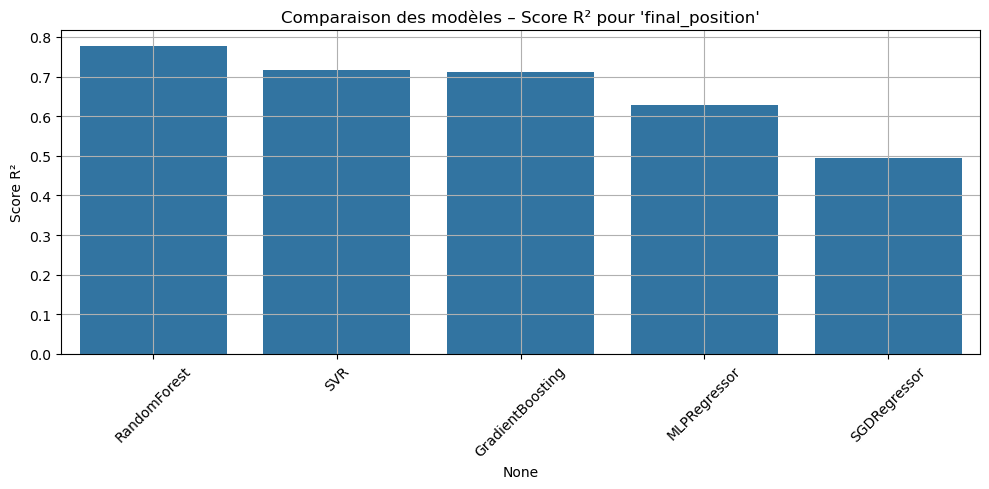

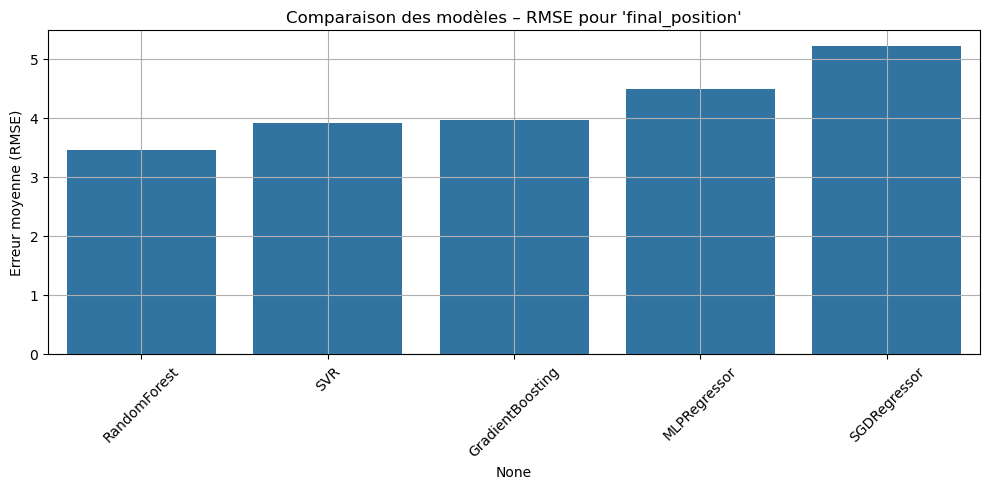

In [7]:
# Focus sur une target spécifique
focus_target = "final_position"  # à modifier selon la cible à explorer

print(f"\n Analyse détaillée pour : {focus_target}")
focus_df = global_results[focus_target].copy()

# Tableau des scores
display(focus_df.round(3))

# Barplot R²
plt.figure(figsize=(10, 5))
sns.barplot(x=focus_df.index, y=focus_df["R² (mean)"])
plt.title(f"Comparaison des modèles – Score R² pour '{focus_target}'")
plt.ylabel("Score R²")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Barplot RMSE
plt.figure(figsize=(10, 5))
sns.barplot(x=focus_df.index, y=focus_df["RMSE (mean)"])
plt.title(f"Comparaison des modèles – RMSE pour '{focus_target}'")
plt.ylabel("Erreur moyenne (RMSE)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Cette cellule permet d’analyser en détail une target choisie, ici désignée par `focus_target`.

Le tableau récapitulatif permet une lecture précise des performances des différents modèles. Les barplots permettent de visualiser rapidement les écarts de performance entre les modèles testés.

## Identifier le meilleur modèle pour une target

In [8]:
# Meilleur modèle basé sur le R² moyen
best_model_name = focus_df["R² (mean)"].idxmax()
print(f" Meilleur modèle pour '{focus_target}' : {best_model_name}")

 Meilleur modèle pour 'final_position' : RandomForest


Grâce à ce bloc, on sélectionne automatiquement le modèle ayant obtenu le meilleur score R² pour la cible choisie.  
Cette sélection conditionnera les étapes suivantes : tuning hyperparamètres, entraînement complet et sauvegarde.

## GridSearchCV sur ce modèle

In [9]:
from sklearn.model_selection import GridSearchCV

#  Paramètres à tester pour le Gradient Boosting
param_grid = {
    "regressor__n_estimators": [100, 200],
    "regressor__max_depth": [3, 5, 7],
    "regressor__learning_rate": [0.05, 0.1]
}

# Nettoyage des données pour la target sélectionnée
df_clean = df[df[focus_target].notna()].copy()
y = df_clean[focus_target]
X = df_clean.drop(columns=[col for col in all_targets if col in df_clean.columns])

# Recréer le preprocessing pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Modèle de base à tuner
base_model = GradientBoostingRegressor(random_state=42)
pipe = Pipeline([
    ("processing", preprocessor),
    ("regressor", base_model)
])

# Lancement de la recherche
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X, y)

# Résultat
print(" Meilleurs hyperparamètres :", grid_search.best_params_)
print(" Meilleur score R² :", round(grid_search.best_score_, 3))


 Meilleurs hyperparamètres : {'regressor__learning_rate': 0.05, 'regressor__max_depth': 7, 'regressor__n_estimators': 100}
 Meilleur score R² : 0.797


Dans cette section, nous utilisons `GridSearchCV` pour optimiser les hyperparamètres du modèle sélectionné.  
L’optimisation est réalisée via une validation croisée à 5 folds, avec le score R² comme critère d’évaluation.

L’objectif est d’ajuster les paramètres du modèle afin d’en améliorer les performances de manière systématique et fiable.

Les combinaisons testées incluent notamment :
- `n_estimators` : nombre d’arbres construits dans l’ensemble,
- `max_depth` : profondeur maximale de chaque arbre,
- `learning_rate` : taux d’apprentissage du boosting.

Ces paramètres ont un impact direct sur la complexité, la précision et la stabilité du modèle.  
Grâce à cette recherche, nous avons pu identifier la configuration la plus performante sur notre jeu de données.

## Sauvegarder le modèle final

In [10]:
import joblib

# Sauvegarde du modèle entraîné
best_final_model = grid_search.best_estimator_
joblib.dump(best_final_model, f"model_regression_{focus_target}.joblib")

print(f" Modèle sauvegardé sous : model_regression_{focus_target}.joblib")


 Modèle sauvegardé sous : model_regression_final_position.joblib


Une fois le modèle entraîné avec ses meilleurs paramètres, nous le sauvegardons avec `joblib`.  
Cela permettra de le recharger rapidement dans un autre notebook ou un script Python, notamment pour réaliser des prédictions sur les données de la saison 2025.

## Bloc pour recharger un modèle sauvegardé et faire des prédictions :

In [11]:
# Recharger un modèle entraîné
loaded_model = joblib.load(f"model_regression_{focus_target}.joblib")

# Exemple d’utilisation : prédire sur de nouvelles données (ex : saison 2025)
# y_pred_2025 = loaded_model.predict(X_2025)


Ce bloc montre comment recharger un modèle sauvegardé et l’utiliser pour faire des prédictions sur de nouvelles données.  
Il est pensé pour la réutilisation future du modèle sur les données de la saison 2025 ou tout autre dataset de Formule 1.

## Bloc pour analyser les erreurs (résidus) 

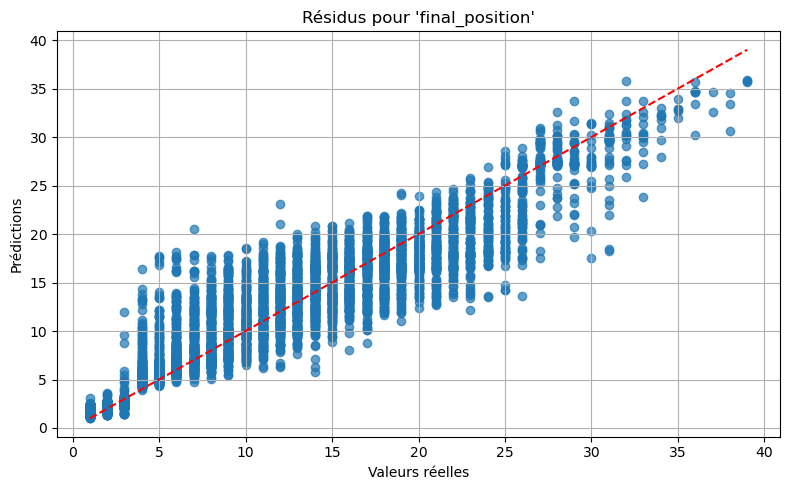

In [12]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Séparer un train/test pour visualiser
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_final_model.fit(X_train, y_train)
y_pred = best_final_model.predict(X_test)

# Analyse des résidus
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red")
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title(f"Résidus pour '{focus_target}'")
plt.grid(True)
plt.tight_layout()
plt.show()

Cette section permet de visualiser graphiquement les erreurs de prédiction du modèle, en comparant les valeurs réelles aux valeurs prédites.

Un alignement des points le long de la diagonale rouge indique une bonne capacité du modèle à restituer fidèlement la réalité.  
Les écarts par rapport à cette diagonale représentent des erreurs de prédiction.

On observe que, dans l’ensemble, les prédictions sont assez cohérentes, bien que certains cas montrent des écarts plus marqués.  
Cela est attendu, notamment sur des cibles sensibles comme `final_position` ou `gained_positions`, fortement influencées par des événements de course imprévisibles.

Ce type de visualisation est utile pour identifier les situations où le modèle sous-performe, par exemple lors de courses atypiques ou d’anomalies stratégiques.

## Conclusion - Bilan de la régression

Ce travail de régression appliqué à la Formule 1 m'a permis de construire, comparer et évaluer différents modèles prédictifs sur des variables continues liées aux performances en course.

Grâce à une approche rigoureuse, incluant :
- un nettoyage systématique des données pour éviter les fuites (data leakage),
- l'utilisation de pipelines complets (imputation, encodage, standardisation),
- une validation croisée à 5 folds pour garantir la robustesse des résultats,

nous avons pu tirer plusieurs enseignements :

- Les performances varient fortement selon la target à prédire : des cibles comme `laps_completed` ou `time_total_seconds` sont bien modélisées (R² > 0.8), tandis que des variables plus instables comme `gained_positions` présentent des scores plus modestes mais réalistes.
- Les modèles ensemblistes (RandomForest et GradientBoosting) dominent très souvent les autres méthodes.
- Le RMSE nous a permis de quantifier précisément l’erreur moyenne, en unités concrètes (tours, secondes, positions ou points).

Enfin, une phase de sélection du meilleur modèle pour chaque target a été mise en place, suivie d’un ajustement des hyperparamètres via `GridSearchCV` et d’une sauvegarde pour une réutilisation future.

Ces résultats serviront de base à la construction d’un système de prédiction pour la saison 2025, en exploitant les modèles les plus fiables identifiés dans ce notebook.
